In [1]:
import torch
import gc

print("=== GPU 상태 확인 ===")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"현재 장치: {torch.cuda.current_device()}")
print(f"GPU 개수: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"\nGPU {i}:")
    print(f"  이름: {torch.cuda.get_device_name(i)}")
    print(f"  메모리 사용량: {torch.cuda.memory_allocated(i)/1e9:.2f} GB")
    print(f"  메모리 예약량: {torch.cuda.memory_reserved(i)/1e9:.2f} GB")
    print(f"  전체 메모리: {torch.cuda.get_device_properties(i).total_memory/1e9:.2f} GB")

=== GPU 상태 확인 ===
CUDA 사용 가능: True
현재 장치: 0
GPU 개수: 4

GPU 0:
  이름: NVIDIA GeForce RTX 4070 Ti SUPER
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.72 GB

GPU 1:
  이름: NVIDIA GeForce RTX 4070 Ti SUPER
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.72 GB

GPU 2:
  이름: NVIDIA RTX A4000
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.75 GB

GPU 3:
  이름: NVIDIA RTX A4000
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.75 GB


In [2]:
import pandas as pd
import hashlib
from pathlib import Path
from tqdm.auto import tqdm

# --- 설정 변수 ---
CACHE_DIR = "cache/"
DATASET_CSV_PATH = "MMSF_dataset.csv"

# --- run_model.ipynb의 해시 함수를 그대로 사용 ---
def _hash(key: str) -> str:
    """비디오 ID를 캐시 파일명으로 변환하는 해시 함수"""
    return hashlib.md5(key.encode()).hexdigest() + ".pt"

def check_cache_existence():
    """
    MMSF_dataset.csv의 video_id에 해당하는 캐시 파일 존재 여부를 확인합니다.
    """
    print(f"✅ 1. '{DATASET_CSV_PATH}' 파일에서 video_id를 로드합니다.")
    
    try:
        df = pd.read_csv(DATASET_CSV_PATH)
    except FileNotFoundError:
        print(f"  - [오류] '{DATASET_CSV_PATH}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return

    if "video_id" not in df.columns:
        print("  - [오류] CSV 파일에 'video_id' 컬럼이 없습니다.")
        return
        
    video_ids = df["video_id"].unique()
    print(f"  - 총 {len(video_ids)}개의 고유 video_id를 찾았습니다.")

    print("\n✅ 2. 각 video_id에 대한 캐시 파일 존재 여부를 검사합니다.")
    
    cache_dir = Path(CACHE_DIR)
    found_count = 0
    not_found_count = 0
    
    # tqdm을 사용하여 진행 상황 표시
    for video_id in tqdm(video_ids, desc="Verifying cache files"):
        # 그래프 캐시 파일 경로 생성
        cache_key = f"video_graph::{video_id}"
        graph_path = cache_dir / _hash(cache_key)
        
        if graph_path.exists():
            # 상세 로그를 보고 싶으면 아래 주석을 해제하세요.
            # print(f"  - [존재] video_id '{video_id}'의 캐시 파일이 있습니다. (경로: {graph_path})")
            found_count += 1
        else:
            # 상세 로그를 보고 싶으면 아래 주석을 해제하세요.
            # print(f"  - [없음] video_id '{video_id}'의 캐시 파일이 없습니다.")
            not_found_count += 1

    print("\n🎉 검사 완료!")
    print("--- 요약 ---")
    print(f"  - 캐시 파일이 존재하는 video_id: {found_count}개")
    print(f"  - 캐시 파일이 존재하지 않는 video_id: {not_found_count}개")
    print(f"  - 확인한 총 video_id: {len(video_ids)}개")

if __name__ == "__main__":
    check_cache_existence()

✅ 1. 'MMSF_dataset.csv' 파일에서 video_id를 로드합니다.
  - 총 6543개의 고유 video_id를 찾았습니다.

✅ 2. 각 video_id에 대한 캐시 파일 존재 여부를 검사합니다.


Verifying cache files:   0%|          | 0/6543 [00:00<?, ?it/s]


🎉 검사 완료!
--- 요약 ---
  - 캐시 파일이 존재하는 video_id: 6016개
  - 캐시 파일이 존재하지 않는 video_id: 527개
  - 확인한 총 video_id: 6543개


In [ ]:
import pandas as pd
import torch

# --- 1. 데이터셋 로드 ---
print("✅ 1. MMSF_dataset.csv 파일을 전체 데이터셋으로 로드합니다.")
try:
    dataset = pd.read_csv("MMSF_dataset.csv")
    print(f"  - 성공! 전체 데이터셋 크기: {len(dataset)}개 샘플")
except FileNotFoundError:
    print("  - [오류] MMSF_dataset.csv 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    dataset = pd.DataFrame() # 오류 방지를 위해 빈 데이터프레임 생성

if not dataset.empty:
    # --- 2. 데이터셋 셔플 ---
    # 재현성을 위해 random_state를 고정하여 데이터셋을 셔플합니다.
    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    print("\n✅ 2. 데이터셋을 무작위로 셔플합니다.")

    # --- 3. 데이터셋 분할 ---
    # 사용자 요청에 따라 7:2:1 비율로 분할합니다.
    print("\n✅ 3. 데이터셋을 7:2:1 비율(훈련:검증:테스트)로 분할합니다.")
    n = len(dataset)
    train_size = int(0.7 * n)
    val_size = int(0.2 * n)
    test_size = n - train_size - val_size

    # 셔플된 데이터프레임을 슬라이싱하여 분할합니다.
    df_train = dataset[:train_size]
    df_val = dataset[train_size:train_size + val_size]
    df_test = dataset[train_size + val_size:]

    print(f"  - 전체 샘플 수: {n}개")
    print("\n--- 분할 결과 ---")
    print(f"  - 훈련 세트 (train):   {len(df_train)}개 (약 {len(df_train)/n*100:.1f}%)")
    print(f"  - 검증 세트 (valid):   {len(df_val)}개 (약 {len(df_val)/n*100:.1f}%)")
    print(f"  - 테스트 세트 (test):    {len(df_test)}개 (약 {len(df_test)/n*100:.1f}%)")

    # --- 4. 분할된 데이터셋 CSV 저장 (선택사항) ---
    # 다음 셀에서 바로 데이터프레임을 사용하므로 저장은 선택사항이지만, 확인을 위해 저장해둡니다.
    try:
        print("\n✅ 분할된 데이터셋을 각각 CSV 파일로 저장합니다.")
        df_train.to_csv("train_dataset.csv", index=False, encoding='utf-8')
        df_val.to_csv("validation_dataset.csv", index=False, encoding='utf-8')
        df_test.to_csv("test_dataset.csv", index=False, encoding='utf-8')
        print("  - 성공! train_dataset.csv, validation_dataset.csv, test_dataset.csv 파일이 생성되었습니다.")
    except Exception as e:
        print(f"\n[오류] CSV 파일 저장 중 문제가 발생했습니다: {e}")

/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseS

✅ 1. 데이터베이스에서 모든 비디오 ID를 로드합니다.
  - 데이터베이스에서 총 7335개의 고유 비디오 ID를 찾았습니다.

✅ 2. 각 비디오 ID에 해당하는 캐시 파일의 존재 여부 및 유효성을 검사합니다.


Verifying cache files: 100%|██████████| 7335/7335 [00:17<00:00, 409.98it/s]


  - 검사 완료. 총 6746개의 유효한 그래프 캐시 파일을 확인했습니다.

✅ 3. 유효한 비디오 ID를 바탕으로 최종 데이터셋을 구성합니다.


Building dataset: 100%|██████████| 6746/6746 [00:00<00:00, 78804.11it/s]


🎉 데이터셋 구성 완료!
  - 총 20664개의 학습 샘플(video_id-person 쌍)을 생성했습니다.

--- 데이터셋 샘플 (상위 5개) ---
      video_id         person  label
0  --6VaQ-Y0R4  Kamala Harris      1
1  --6VaQ-Y0R4   Gavin Newsom      1
2  --6VaQ-Y0R4   Donald Trump      0
3  -0KVHlRomHw   Nigel Farage      1
4  -0KVHlRomHw     Tony Blair      1


## 샘플토큰 768, focal, am, focal-am loss function code

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hashlib
from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# ===== VRAM logger =====
def log_vram(stage: str, device=None):
    if not torch.cuda.is_available():
        print(f"[VRAM] {stage}: CUDA not available")
        return
    if device is None:
        device = torch.cuda.current_device()
    torch.cuda.synchronize(device)
    alloc = torch.cuda.memory_allocated(device) / (1024**3)
    reserv = torch.cuda.memory_reserved(device) / (1024**3)
    maxal = torch.cuda.max_memory_allocated(device) / (1024**3)
    print(f"[VRAM] {stage:<28} | alloc={alloc:6.2f} GB | reserved={reserv:6.2f} GB | max={maxal:6.2f} GB")


# ===================================================================
# 0. 전역 설정
# ===================================================================
CACHE_DIR = "cache/"
RANDOM_STATE = 42
max_norm = 5
THRESHOLD = 0.5                 # ← 임계값 고정
torch.manual_seed(RANDOM_STATE)

# === 그래디언트 축적 스텝 수 ===
ACCUM_STEPS = 128  # 배치크기(현재 1) * ACCUM_STEPS = 가상 배치 크기
print("✅ 실행 시작")


# ===================================================================
# 1. 데이터셋 및 데이터로더
# ===================================================================
print("✅ 1. 분할된 CSV 파일들을 로드하여 데이터셋을 생성합니다.")

class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id, person, label = meta['video_id'], meta['person'], meta['label']
        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # 비어 있는 그래프는 스킵
            if getattr(graph_data, "num_nodes", 0) == 0:
                return None

            # 잘못된 엣지 인덱스 방어적 보정
            if getattr(graph_data, "num_edges", 0) > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # 추가 메타
            graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person = person
            return graph_data
        except Exception:
            # 캐시가 없거나 로드 실패 시 스킵
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None


train_dataset = ExperimentDataset(df_train, CACHE_DIR)
val_dataset   = ExperimentDataset(df_val, CACHE_DIR)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"  - 훈련 데이터로더: {len(train_loader)}개 배치")
print(f"  - 검증 데이터로더: {len(val_loader)}개 배치")
print(f"  - 그래디언트 축적: ACCUM_STEPS={ACCUM_STEPS} → 가상 배치 크기 = {1 * ACCUM_STEPS}")


# ===================================================================
# 2. 손실 함수들 (Focal / AM / AM+Focal)
# ===================================================================
class FocalBinaryLoss(nn.Module):
    """
    Binary Focal Loss
    - gamma: hard sample 강조(1.5~2.0 권장 시작)
    - alpha: 클래스 가중치(5:5 균형이면 보통 None)
    """
    def __init__(self, gamma: float = 1.8, alpha: float | None = None,
                 reduction: str = "mean", eps: float = 1e-8):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p   = torch.sigmoid(logits)
        pt  = targets * p + (1 - targets) * (1 - p)  # 정답확률
        modulating = (1 - pt).clamp_(self.eps, 1 - self.eps) ** self.gamma
        loss = modulating * bce
        if self.alpha is not None:
            alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
            loss = alpha_t * loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss


class AMBinaryCE(nn.Module):
    """
    Additive-Margin BCE
    - margin m을 로짓에 직접 부여해 결정경계 바깥으로 밀어냄
    - m: 0.1 ~ 0.4 권장 시작
    """
    def __init__(self, margin: float = 0.2, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        z_m = torch.where(targets > 0.5, logits - self.margin, logits + self.margin)
        return F.binary_cross_entropy_with_logits(z_m, targets, reduction=self.reduction)


class AMFocalBinaryLoss(nn.Module):
    """
    AM-Focal (추천 기본: margin 이후 focal 적용)
    - combine_mode="margin_then_focal": z'에 focal 적용
    - combine_mode="sum": focal(z) + lam * am_bce(z)
    """
    def __init__(self,
                 gamma: float = 1.8,
                 margin: float = 0.2,
                 alpha: float | None = None,
                 lam: float = 0.3,
                 combine_mode: str = "margin_then_focal",
                 reduction: str = "mean"):
        super().__init__()
        self.focal = FocalBinaryLoss(gamma=gamma, alpha=alpha, reduction=reduction)
        self.am    = AMBinaryCE(margin=margin, reduction=reduction)
        self.lam   = lam
        self.combine_mode = combine_mode
        self.reduction = reduction
        self.margin = margin

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if self.combine_mode == "margin_then_focal":
            z_m = torch.where(targets > 0.5, logits - self.margin, logits + self.margin)
            return self.focal(z_m, targets)
        # 대안: 가중합 방식
        return self.focal(logits, targets) + self.lam * self.am(logits, targets)


# ===================================================================
# 3. 모델 정의 (R-GCN + ChatGLM2 + LoRA)
# ===================================================================
print("\n✅ 3. GCN을 포함한 전체 모델(GraphTokenManager)을 정의합니다.")

class RGCNEncoder(nn.Module):
    def __init__(self, in_dim=768, num_rel=8, num_layers=3, dropout=0.0):
        super().__init__()
        true_num_relations = num_rel
        self.layers = nn.ModuleList(
            RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
        )
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        h = x.to(torch.float32)
        safe_edge_type = edge_type.to(torch.long)
        for conv in self.layers:
            h = conv(h, edge_index, safe_edge_type)
            h = self.act(h)
            h = self.drop(h)
        return h


class GraphTokenManager(nn.Module):
    def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8,
                 loss_fn: nn.Module | None = None):
        super().__init__()

        # ChatGLM2-6B는 FP16, device_map="auto"
        self.glm = AutoModel.from_pretrained(
            glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
        )
        self.base_device = self.glm.get_input_embeddings().weight.device
        self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

        # ---- GCN/Linear/Head는 FP32 유지 ----
        self.gcn = RGCNEncoder(in_dim=768, num_rel=8, num_layers=gcn_layers).to(self.base_device)
        self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
        self.cls_head = nn.Linear(4096, 1).to(self.base_device)

        # LoRA: GLM의 QKV에만 적용
        lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
        self.glm = get_peft_model(self.glm, lora_cfg)

        # 길이 제한 및 체크포인팅(메모리 절감)
        self.max_graph_tokens = 768
        if hasattr(self.glm, "gradient_checkpointing_enable"):
            self.glm.gradient_checkpointing_enable()

        # 손실 함수 주입
        self.loss_fn = loss_fn if loss_fn is not None else nn.BCEWithLogitsLoss()

    def _num_text_tokens(self, data) -> int:
        n = 0
        if hasattr(data, "node_meta"):
            if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
                n = int(data.node_meta[0].get("text_nodes", 0))
            elif isinstance(data.node_meta, dict):
                n = int(data.node_meta.get("text_nodes", 0))
        return max(n, 0)

    def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
        T = seq.size(0)
        if T <= K:
            return seq
        chunk = math.ceil(T / K)
        pad_len = chunk * K - T
        if pad_len > 0:
            pad = seq[-1:].repeat(pad_len, 1)
            seq = torch.cat([seq, pad], dim=0)
        seq = seq.view(K, chunk, -1).mean(dim=1) # [K, D]
        return seq

    def _get_glm_backbone(self):
        backbone = getattr(self.glm, "transformer", None)
        if backbone is None:
            backbone = getattr(self.glm, "model", None)
        if backbone is None and hasattr(self.glm, "base_model"):
            backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
        if backbone is None:
            raise RuntimeError("ChatGLM backbone not found: expected `.transformer` or `.model` inside PEFT wrapper.")
        return backbone

    def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
        device = self.base_device
        if debug: log_vram("forward/start", device)

        # ---- GCN 입력은 FP32 ----
        data.x = data.x.to(torch.float32)
        data.edge_index = data.edge_index.to(torch.long)
        data.edge_type  = data.edge_type.to(torch.long)
        data = data.to(device)
        if debug:
            print(f"[DBG] x={tuple(data.x.shape)}, edge_index={tuple(data.edge_index.shape)}, edge_type={tuple(data.edge_type.shape)}")
            log_vram("after data.to(device)", device)

        # 1) R-GCN 인코딩 (FP32)
        node_h = self.gcn(data.x, data.edge_index, data.edge_type)
        if debug:
            print(f"[DBG] node_h={tuple(node_h.shape)} (dtype={node_h.dtype})")
            log_vram("after GCN", device)

        # 2) 텍스트 토큰만 선택 (없으면 전체 사용)
        num_text_tokens = self._num_text_tokens(data)
        utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
        if utterance_h.size(0) == 0:
            utterance_h = node_h.mean(dim=0, keepdim=True)
        if debug:
            print(f"[DBG] num_text_tokens={num_text_tokens}, utterance_h={tuple(utterance_h.shape)}")
            log_vram("after choosing text nodes", device)

        # 3) 청크 평균 풀링으로 길이 축약
        utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)

        # 4) 그래프 토큰 차원 올리기 → [1, K, 4096] (FP32)
        graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
        if debug:
            print(f"[DBG] graph_tokens_fp32={tuple(graph_tokens_fp32.shape)} (dtype={graph_tokens_fp32.dtype})")
            log_vram("after proj_up", device)

        # 5) 프롬프트 임베딩 (FP16)과 결합 (그래프 토큰을 FP16으로 캐스팅)
        prompt = (
            f"指令：你的任务是分析上下文，并预测 {person} 的搜索量是否会出现异常。"
            f"请在内部进行逐步推理，然后生成一个能够明确映射到最终选项的输出表示："
            f"0（无异常）或 1（异常）。\n"
            f"上下文："
        )
        tok = self.tokenizer(prompt, return_tensors="pt").to(device)
        prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16
        if debug:
            print(f"[DBG] prompt_len={prompt_emb.size(1)}, prompt_emb={tuple(prompt_emb.shape)} (dtype={prompt_emb.dtype})")
            log_vram("after prompt_emb", device)

        graph_tokens = graph_tokens_fp32.to(dtype=prompt_emb.dtype)
        inputs_embeds = torch.cat([prompt_emb, graph_tokens], dim=1)
        if debug:
            total_len = inputs_embeds.size(1)
            print(f"[DBG] inputs_embeds={tuple(inputs_embeds.shape)}  (total_seq_len={total_len})")
            log_vram("after concat inputs_embeds", device)

        # dummy input_ids (길이만 맞추기용)
        b, s, _ = inputs_embeds.size()
        dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

        if debug: log_vram("before GLM forward", device)

        # GLM backbone을 직접 호출하여 last_hidden_state 획득
        backbone = self._get_glm_backbone()
        transformer_out = backbone(
            input_ids=dummy_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
            use_cache=False,
            output_hidden_states=False,
        )

        if debug: log_vram("after GLM forward", device)

        # 6) 그래프 토큰 구간만 평균 → cls_head는 FP32
        glen = prompt_emb.size(1)
        last_hidden = transformer_out.last_hidden_state      # [B, S, H]
        graph_repr = last_hidden[:, glen:, :].mean(dim=1)   # [B, H]

        head_dev = self.cls_head.weight.device
        graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

        if debug:
            print(f"[DBG] last_hidden={tuple(last_hidden.shape)}, graph_repr={tuple(graph_repr.shape)}")
            log_vram("after mean pool", device)

        logits = self.cls_head(graph_repr).squeeze(-1)  # [B]
        if debug:
            print(f"[DBG] logits={tuple(logits.shape)} (dtype={logits.dtype})")
            log_vram("after cls_head", device)

        if label is None:
            return logits, None

        # 손실
        targets = label.to(logits.device, dtype=torch.float32)
        loss = self.loss_fn(logits, targets)
        if debug: log_vram("after loss", device)
        return logits, loss


# ===================================================================
# 4. 훈련 + 평가 (정확도 기준 체크포인트 / 임계값 0.5 고정)
# ===================================================================
print("\n✅ 4. 모델 훈련을 준비하고 10 에포크를 실행합니다.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - 사용 장치: {device}")

# ===== 손실/실험 설정 =====
LOSS_MODE = "focal"          # "focal" | "am" | "am_focal"
FOCAL_GAMMA = 1.8
FOCAL_ALPHA = None           # 5:5 균형이면 보통 None
AM_MARGIN   = 0.2
AMF_LAMBDA  = 0.3
COMBINE_MODE = "margin_then_focal"

def make_loss():
    if LOSS_MODE == "focal":
        return FocalBinaryLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
    elif LOSS_MODE == "am":
        return AMBinaryCE(margin=AM_MARGIN)
    elif LOSS_MODE == "am_focal":
        return AMFocalBinaryLoss(
            gamma=FOCAL_GAMMA,
            margin=AM_MARGIN,
            alpha=FOCAL_ALPHA,
            lam=AMF_LAMBDA,
            combine_mode=COMBINE_MODE
        )
    else:
        raise ValueError(f"Unknown LOSS_MODE: {LOSS_MODE}")

loss_fn = make_loss()
model = GraphTokenManager(loss_fn=loss_fn)

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

print("  - 모델 및 옵티마이저 준비 완료.")
print("\n--- 훈련 시작 (10 에포크) ---")

N_EPOCHS = 10
best_acc = -1.0
best_state = None

model.train()
global_step = 0

# ----------------- 평가 함수 (임계값 0.5 고정, 손실/정확도/F1 동시 보고) -----------------
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()
    probs_list, labels_list = [], []
    total_val_loss, val_steps = 0.0, 0

    for batch in tqdm(loader, desc="Evaluating"):
        if batch is None:
            continue
        g: Data = batch[0] if isinstance(batch, list) else batch
        logits, loss = model(g, g.person, g.label, debug=False)
        probs = torch.sigmoid(logits.detach())
        probs_list.append(probs.float().cpu())
        labels_list.append(g.label.detach().float().cpu())

        if loss is not None and torch.isfinite(loss):
            total_val_loss += float(loss.item())
            val_steps += 1

    if len(probs_list) == 0:
        print("No validation samples.")
        return {}

    y_prob = torch.cat(probs_list).view(-1)        # [N]
    y_true = torch.cat(labels_list).view(-1)       # [N]
    y_true = (y_true > 0.5).float()

    # @0.5 기준
    y_pred = (y_prob >= THRESHOLD).float()
    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    tn = ((y_pred == 0) & (y_true == 0)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()

    def safe_div(a, b):
        return (a / b) if b != 0 else 0.0

    acc   = safe_div(tp + tn, tp + tn + fp + fn)
    prec  = safe_div(tp, tp + fp)
    rec   = safe_div(tp, tp + fn)
    f1_05 = safe_div(2 * prec * rec, (prec + rec)) if (prec + rec) > 0 else 0.0

    # ROC-AUC (rank-based)
    def roc_auc_score_torch(y_true_, y_score_):
        y_true_ = y_true_.view(-1)
        y_score_ = y_score_.view(-1)
        n = y_true_.numel()
        n_pos = int((y_true_ == 1).sum().item())
        n_neg = n - n_pos
        if n_pos == 0 or n_neg == 0:
            return float('nan')
        _, order = torch.sort(y_score_)
        ranks = torch.empty_like(order, dtype=torch.float)
        ranks[order] = torch.arange(1, n + 1, dtype=torch.float)
        sum_ranks_pos = ranks[y_true_ == 1].sum()
        auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
        return float(auc.item())

    # PR-AUC (Average Precision)
    def average_precision_torch(y_true_, y_score_):
        scores, idx = torch.sort(y_score_.view(-1), descending=True)
        y_sorted = y_true_.view(-1)[idx]
        cum_tp = torch.cumsum(y_sorted, dim=0)
        ranks  = torch.arange(1, y_sorted.numel() + 1, dtype=torch.float)
        precision_at_k = cum_tp / ranks
        num_pos = y_sorted.sum()
        if num_pos.item() == 0:
            return float('nan')
        ap = (precision_at_k * y_sorted).sum() / num_pos
        return float(ap.item())

    roc_auc = roc_auc_score_torch(y_true, y_prob)
    pr_auc  = average_precision_torch(y_true, y_prob)
    val_loss_avg = (total_val_loss / max(val_steps, 1))

    metrics = {
        "val_loss": val_loss_avg,
        "accuracy": acc,
        "precision@0.5": prec,
        "recall@0.5": rec,
        "f1@0.5": f1_05,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix@0.5": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
        "threshold": THRESHOLD,
    }
    return metrics


# ----------------- 학습 루프 (정확도 기준 체크포인트, 풍부한 로그 출력) -----------------
N_EPOCHS = 10
for epoch in range(1, N_EPOCHS + 1):
    model.train()
    total_loss = 0.0          # 에포크당 마이크로 배치 손실 합
    num_steps  = 0            # 에포크당 마이크로 배치 카운트
    accum_step = 0            # 누적 스텝 카운터

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

    # 최초 한 번만 zero_grad
    optimizer.zero_grad(set_to_none=True)

    for batch in progress_bar:
        if batch is None:
            continue
        graph_batch: Data = batch[0] if isinstance(batch, list) else batch

        logits, loss = model(graph_batch, graph_batch.person, graph_batch.label, debug=False)

        if loss is not None and torch.isfinite(loss):
            # 축적: loss를 ACCUM_STEPS로 나눠서 역전파
            (loss / ACCUM_STEPS).backward()

            accum_step += 1
            total_loss += float(loss.item())
            num_steps  += 1

            # 진행 표시 (현재 누적 단계 / ACCUM_STEPS)
            progress_bar.set_postfix(
                loss=f"{loss.item():.4f}",
                accum=f"{accum_step % ACCUM_STEPS or ACCUM_STEPS}/{ACCUM_STEPS}"
            )

            # ACCUM_STEPS 마다 최적화 스텝
            if accum_step % ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                global_step += 1

    # 에포크 종료 시, 남은 누적 그라디언트 처리
    if accum_step % ACCUM_STEPS != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        global_step += 1

    train_loss_avg = (total_loss / max(num_steps, 1))

    # --- 에폭 종료 후 검증 & 로그 출력 ---
    val_metrics = evaluate(model, val_loader)
    val_acc = val_metrics.get('accuracy', float('nan'))
    val_f1  = val_metrics.get('f1@0.5', float('nan'))
    val_loss = val_metrics.get('val_loss', float('nan'))
    prec = val_metrics.get('precision@0.5', float('nan'))
    rec  = val_metrics.get('recall@0.5', float('nan'))
    roc_auc = val_metrics.get('roc_auc', float('nan'))
    pr_auc  = val_metrics.get('pr_auc', float('nan'))
    cm = val_metrics.get('confusion_matrix@0.5', {})

    print(
        f"[Epoch {epoch}] "
        f"train_loss={train_loss_avg:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc@0.5={val_acc:.4f} | "
        f"val_f1@0.5={val_f1:.4f} | "
        f"prec@0.5={prec:.4f} | rec@0.5={rec:.4f} | "
        f"ROC-AUC={roc_auc:.4f} | PR-AUC={pr_auc:.4f} | "
        f"CM@0.5={cm}"
    )

    # --- 체크포인트 갱신(정확도 @0.5 기준) ---
    cur_acc = val_acc if isinstance(val_acc, float) else -1.0
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_acc": best_acc,                 # 정확도 기록
            "metrics": val_metrics,               # 해당 에포크의 전체 지표 저장
            "loss_mode": LOSS_MODE,
            "accum_steps": ACCUM_STEPS,
            "selection_metric": "accuracy@0.5",   # 선택 기준 명시
            "threshold": THRESHOLD,
        }
        torch.save(best_state, "best_checkpoint.pt")
        print(f"✅ Saved best checkpoint: epoch={epoch}, best_acc={best_acc:.4f}")

print(f"--- 훈련 완료 ({N_EPOCHS} 에포크) ---")
if 'best_state' in globals() and best_state is not None:
    m = best_state.get("metrics", {})
    print(
        "🏆 Best checkpoint summary\n"
        f"  - epoch: {best_state['epoch']}\n"
        f"  - selection_metric: {best_state.get('selection_metric','n/a')} (thr={best_state.get('threshold', THRESHOLD)})\n"
        f"  - best_acc: {best_state['best_acc']:.4f}\n"
        f"  - val_loss: {m.get('val_loss', float('nan')):.4f}\n"
        f"  - f1@0.5: {m.get('f1@0.5', float('nan')):.4f}\n"
        f"  - precision@0.5: {m.get('precision@0.5', float('nan')):.4f}\n"
        f"  - recall@0.5: {m.get('recall@0.5', float('nan')):.4f}\n"
        f"  - ROC-AUC: {m.get('roc_auc', float('nan')):.4f}\n"
        f"  - PR-AUC: {m.get('pr_auc', float('nan')):.4f}\n"
        f"  - CM@0.5: {m.get('confusion_matrix@0.5', {})}\n"
        f"  - loss_mode: {best_state.get('loss_mode','n/a')}\n"
        f"  - accum_steps: {best_state.get('accum_steps','n/a')}\n"
        f"  - file: best_checkpoint.pt"
    )
else:
    print("⚠️ Best checkpoint was not updated.")


✅ 실행 시작
✅ 1. 분할된 CSV 파일들을 로드하여 데이터셋을 생성합니다.
  - 훈련 데이터로더: 14464개 배치
  - 검증 데이터로더: 2067개 배치
  - 그래디언트 축적: ACCUM_STEPS=128 → 가상 배치 크기 = 128

✅ 3. GCN을 포함한 전체 모델(GraphTokenManager)을 정의합니다.

✅ 4. 모델 훈련을 준비하고 10 에포크를 실행합니다.
  - 사용 장치: cuda:0


Loading checkpoint shards:  29%|██▊       | 2/7 [00:03<00:08,  1.64s/it]


KeyboardInterrupt: 

: 

## 기본적인 bce 비용함수 적용코드 샘플 토큰 768

In [7]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# import hashlib
# from pathlib import Path
# import math
# import pandas as pd
# import torch
# import torch.nn as nn
# from tqdm.auto import tqdm

# from torch.utils.data import Dataset
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn import RGCNConv

# from transformers import AutoTokenizer, AutoModel
# from peft import LoraConfig, get_peft_model


# # ===== VRAM logger =====
# def log_vram(stage: str, device=None):
#     if not torch.cuda.is_available():
#         print(f"[VRAM] {stage}: CUDA not available")
#         return
#     if device is None:
#         device = torch.cuda.current_device()
#     torch.cuda.synchronize(device)
#     alloc = torch.cuda.memory_allocated(device) / (1024**3)
#     reserv = torch.cuda.memory_reserved(device) / (1024**3)
#     maxal = torch.cuda.max_memory_allocated(device) / (1024**3)
#     print(f"[VRAM] {stage:<28} | alloc={alloc:6.2f} GB | reserved={reserv:6.2f} GB | max={maxal:6.2f} GB")


# # ===================================================================
# # 0. 전역 설정
# # ===================================================================
# CACHE_DIR = "cache/"
# RANDOM_STATE = 42
# torch.manual_seed(RANDOM_STATE)

# print("✅ 실행 시작")


# # ===================================================================
# # 1. 데이터셋 및 데이터로더
# # ===================================================================
# print("✅ 1. 분할된 CSV 파일들을 로드하여 데이터셋을 생성합니다.")

# class ExperimentDataset(Dataset):
#     def __init__(self, dataframe, cache_dir):
#         self.samples = dataframe.to_dict('records')
#         self.cache_dir = Path(cache_dir)

#     def __len__(self):
#         return len(self.samples)

#     @staticmethod
#     def _hash(key: str) -> str:
#         return hashlib.md5(key.encode()).hexdigest() + ".pt"

#     def __getitem__(self, idx: int) -> Data | None:
#         meta = self.samples[idx]
#         video_id, person, label = meta['video_id'], meta['person'], meta['label']
#         graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
#         try:
#             graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

#             # 비어 있는 그래프는 스킵
#             if graph_data.num_nodes == 0:
#                 return None

#             # 잘못된 엣지 인덱스 방어적 보정
#             if graph_data.num_edges > 0:
#                 mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
#                 if not mask.all():
#                     graph_data.edge_index = graph_data.edge_index[:, mask]
#                     if hasattr(graph_data, 'edge_type'):
#                         graph_data.edge_type = graph_data.edge_type[mask]

#             # 추가 메타
#             graph_data.label = torch.tensor([label], dtype=torch.float)
#             graph_data.person = person
#             return graph_data
#         except Exception:
#             # 캐시가 없거나 로드 실패 시 스킵
#             return None


# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     return batch if batch else None


# df_train = pd.read_csv("train_dataset.csv")
# df_val = pd.read_csv("validation_dataset.csv")

# train_dataset = ExperimentDataset(df_train, CACHE_DIR)
# val_dataset   = ExperimentDataset(df_val, CACHE_DIR)

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_fn)
# val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)

# print(f"  - 훈련 데이터로더: {len(train_loader)}개 배치")
# print(f"  - 검증 데이터로더: {len(val_loader)}개 배치")


# # ===================================================================
# # 2. 모델 정의 (R-GCN + ChatGLM2 + LoRA)
# # ===================================================================
# print("\n✅ 2. GCN을 포함한 전체 모델(GraphTokenManager)을 정의합니다.")

# class RGCNEncoder(nn.Module):
#     def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
#         super().__init__()
#         # 관계 타입에 +1 오프셋을 주기 위해 dummy relation 포함
#         true_num_relations = num_rel + 1
#         self.layers = nn.ModuleList(
#             RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
#         )
#         self.act  = nn.ReLU()
#         self.drop = nn.Dropout(dropout)

#     def forward(self, x, edge_index, edge_type):
#         # ---- FP32 유지 ----
#         h = x.to(torch.float32)
#         safe_edge_type = edge_type.to(torch.long) + 1  # -1 방지용 오프셋
#         for conv in self.layers:
#             h = conv(h, edge_index, safe_edge_type)
#             h = self.act(h)
#             h = self.drop(h)
#         return h


# class GraphTokenManager(nn.Module):
#     def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
#         super().__init__()

#         # ChatGLM2-6B는 FP16, device_map="auto"
#         self.glm = AutoModel.from_pretrained(
#             glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
#         )
#         self.base_device = self.glm.get_input_embeddings().weight.device
#         self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

#         # ---- GCN/Linear/Head는 FP32 유지 ----
#         self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
#         self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
#         self.cls_head = nn.Linear(4096, 1).to(self.base_device)

#         # LoRA: GLM의 QKV에만 적용
#         lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
#         self.glm = get_peft_model(self.glm, lora_cfg)

#         # 길이 제한 및 체크포인팅(메모리 절감)
#         self.max_graph_tokens = 768   # 필요시 256~512로 조정
#         if hasattr(self.glm, "gradient_checkpointing_enable"):
#             self.glm.gradient_checkpointing_enable()

#     def _num_text_tokens(self, data) -> int:
#         n = 0
#         if hasattr(data, "node_meta"):
#             if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
#                 n = int(data.node_meta[0].get("text_nodes", 0))
#             elif isinstance(data.node_meta, dict):
#                 n = int(data.node_meta.get("text_nodes", 0))
#         return max(n, 0)

#     def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
#         """
#         seq: [T, D] (FP32)
#         K:   target length (<= T). if T<=K, returns seq as-is.
#         청크 평균 풀링: T를 K로 요약. 모든 토큰에 gradient가 흐름.
#         """
#         T = seq.size(0)
#         if T <= K:
#             return seq
#         chunk = math.ceil(T / K)
#         pad_len = chunk * K - T
#         if pad_len > 0:
#             pad = seq[-1:].repeat(pad_len, 1)
#             seq = torch.cat([seq, pad], dim=0)   # [chunk*K, D]
#         seq = seq.view(K, chunk, -1).mean(dim=1) # [K, D]
#         return seq

#     def _get_glm_backbone(self):
#         # peft wrapping 후 구조까지 커버
#         backbone = getattr(self.glm, "transformer", None)
#         if backbone is None:
#             backbone = getattr(self.glm, "model", None)
#         if backbone is None and hasattr(self.glm, "base_model"):
#             backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
#         if backbone is None:
#             raise RuntimeError("ChatGLM backbone not found: expected `.transformer` or `.model` inside PEFT wrapper.")
#         return backbone

#     def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
#         device = self.base_device
#         if debug: log_vram("forward/start", device)

#         # ---- GCN 입력은 FP32 ----
#         data.x = data.x.to(torch.float32)
#         data.edge_index = data.edge_index.to(torch.long)
#         data.edge_type  = data.edge_type.to(torch.long)
#         data = data.to(device)
#         if debug:
#             print(f"[DBG] x={tuple(data.x.shape)}, edge_index={tuple(data.edge_index.shape)}, edge_type={tuple(data.edge_type.shape)}")
#             log_vram("after data.to(device)", device)

#         # 1) R-GCN 인코딩 (FP32)
#         node_h = self.gcn(data.x, data.edge_index, data.edge_type)
#         if debug:
#             print(f"[DBG] node_h={tuple(node_h.shape)} (dtype={node_h.dtype})")
#             log_vram("after GCN", device)

#         # 2) 텍스트 토큰만 선택 (없으면 전체 사용)
#         num_text_tokens = self._num_text_tokens(data)
#         utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
#         if utterance_h.size(0) == 0:
#             utterance_h = node_h.mean(dim=0, keepdim=True)
#         if debug:
#             print(f"[DBG] num_text_tokens={num_text_tokens}, utterance_h={tuple(utterance_h.shape)}")
#             log_vram("after choosing text nodes", device)

#         # 3) 청크 평균 풀링으로 길이 축약 (핵심)
#         utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)  # [K, 768], K<=max_graph_tokens

#         # 4) 그래프 토큰 차원 올리기 → [1, K, 4096] (FP32)
#         graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
#         if debug:
#             print(f"[DBG] graph_tokens_fp32={tuple(graph_tokens_fp32.shape)} (dtype={graph_tokens_fp32.dtype})")
#             log_vram("after proj_up", device)

#         # 5) 프롬프트 임베딩 (FP16)과 결합 (그래프 토큰을 FP16으로 캐스팅)
#         prompt = (
#             f"Instruction: Please predict whether Google search volume for {person} "
#             f"will exhibit an anomaly (0=no, 1=yes).\n"
#             f"Input: "
#         )
#         tok = self.tokenizer(prompt, return_tensors="pt").to(device)
#         prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16
#         if debug:
#             print(f"[DBG] prompt_len={prompt_emb.size(1)}, prompt_emb={tuple(prompt_emb.shape)} (dtype={prompt_emb.dtype})")
#             log_vram("after prompt_emb", device)

#         graph_tokens = graph_tokens_fp32.to(dtype=prompt_emb.dtype)  # FP16으로 변환
#         inputs_embeds = torch.cat([prompt_emb, graph_tokens], dim=1)
#         if debug:
#             total_len = inputs_embeds.size(1)
#             print(f"[DBG] inputs_embeds={tuple(inputs_embeds.shape)}  (total_seq_len={total_len})")
#             log_vram("after concat inputs_embeds", device)

#         # dummy input_ids (길이만 맞추기용)
#         b, s, _ = inputs_embeds.size()
#         dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

#         if debug: log_vram("before GLM forward", device)

#         # ✅ GLM backbone을 직접 호출하여 last_hidden_state 획득
#         backbone = self._get_glm_backbone()
#         transformer_out = backbone(
#             input_ids=dummy_ids,
#             inputs_embeds=inputs_embeds,
#             return_dict=True,
#             use_cache=False,
#             output_hidden_states=False,   # 메모리 절감
#         )

#         if debug: log_vram("after GLM forward", device)

#         # 6) 그래프 토큰 구간만 평균 → cls_head는 FP32
#         glen = prompt_emb.size(1)
#         last_hidden = transformer_out.last_hidden_state      # [B, S, H]
#         graph_repr = last_hidden[:, glen:, :].mean(dim=1)   # [B, H]

#         # cls_head가 위치한 디바이스로 이동
#         head_dev = self.cls_head.weight.device
#         graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

#         if debug:
#             print(f"[DBG] last_hidden={tuple(last_hidden.shape)}, graph_repr={tuple(graph_repr.shape)}")
#             log_vram("after mean pool", device)

#         logits = self.cls_head(graph_repr).squeeze(-1)  # [B]
#         if debug:
#             print(f"[DBG] logits={tuple(logits.shape)} (dtype={logits.dtype})")
#             log_vram("after cls_head", device)

#         if label is None:
#             return logits, None

#         loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
#         if debug: log_vram("after loss", device)
#         return logits, loss


# # ===================================================================
# # 3. 훈련 + 평가 (지표 다양화, F1 기준) + 베스트 체크포인트 저장
# # ===================================================================
# print("\n✅ 3. 모델 훈련을 준비하고 10 에포크를 실행합니다.")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"  - 사용 장치: {device}")

# model = GraphTokenManager()
# optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

# print("  - 모델 및 옵티마이저 준비 완료.")
# print("\n--- 훈련 시작 (10 에포크) ---")

# N_EPOCHS = 10
# best_f1 = -1.0
# best_threshold = 0.5
# best_state = None

# model.train()
# global_step = 0

# # ----------------- 평가 함수 (다양한 지표 + F1 기준) -----------------
# @torch.no_grad()
# def evaluate(model: nn.Module, loader: DataLoader, device=None):
#     model.eval()
#     probs_list, labels_list = [], []

#     for batch in tqdm(loader, desc="Evaluating"):
#         if batch is None:
#             continue
#         g: Data = batch[0] if isinstance(batch, list) else batch
#         logits, _ = model(g, g.person, g.label, debug=False)
#         probs = torch.sigmoid(logits.detach())
#         probs_list.append(probs.float().cpu())
#         labels_list.append(g.label.detach().float().cpu())

#     if len(probs_list) == 0:
#         print("No validation samples.")
#         return {}

#     y_prob = torch.cat(probs_list).view(-1)        # [N]
#     y_true = torch.cat(labels_list).view(-1)       # [N]
#     y_true = (y_true > 0.5).float()

#     # 기본 임계값 0.5
#     y_pred_05 = (y_prob >= 0.5).float()
#     tp = ((y_pred_05 == 1) & (y_true == 1)).sum().item()
#     tn = ((y_pred_05 == 0) & (y_true == 0)).sum().item()
#     fp = ((y_pred_05 == 1) & (y_true == 0)).sum().item()
#     fn = ((y_pred_05 == 0) & (y_true == 1)).sum().item()

#     def safe_div(a, b):
#         return (a / b) if b != 0 else 0.0

#     acc   = safe_div(tp + tn, tp + tn + fp + fn)
#     prec  = safe_div(tp, tp + fp)
#     rec   = safe_div(tp, tp + fn)
#     f1_05 = safe_div(2 * prec * rec, prec + rec)

#     # 최적 F1 임계값 탐색 (grid)
#     best_f1_local, best_t, best_prec, best_rec = 0.0, 0.5, 0.0, 0.0
#     for t in torch.linspace(0.05, 0.95, steps=19):
#         y_pred = (y_prob >= t).float()
#         tp_t = ((y_pred == 1) & (y_true == 1)).sum().item()
#         fp_t = ((y_pred == 1) & (y_true == 0)).sum().item()
#         fn_t = ((y_pred == 0) & (y_true == 1)).sum().item()
#         p_t  = safe_div(tp_t, tp_t + fp_t)
#         r_t  = safe_div(tp_t, tp_t + fn_t)
#         f1_t = safe_div(2 * p_t * r_t, p_t + r_t)
#         if f1_t > best_f1_local:
#             best_f1_local, best_t, best_prec, best_rec = f1_t, float(t.item()), p_t, r_t

#     # ROC-AUC (rank-based, ties=average)
#     def roc_auc_score_torch(y_true_, y_score_):
#         y_true_ = y_true_.view(-1)
#         y_score_ = y_score_.view(-1)
#         n = y_true_.numel()
#         n_pos = int((y_true_ == 1).sum().item())
#         n_neg = n - n_pos
#         if n_pos == 0 or n_neg == 0:
#             return float('nan')
#         _, order = torch.sort(y_score_)
#         ranks = torch.empty_like(order, dtype=torch.float)
#         ranks[order] = torch.arange(1, n + 1, dtype=torch.float)
#         sum_ranks_pos = ranks[y_true_ == 1].sum()
#         auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
#         return float(auc.item())

#     # PR-AUC (Average Precision)
#     def average_precision_torch(y_true_, y_score_):
#         scores, idx = torch.sort(y_score_.view(-1), descending=True)
#         y_sorted = y_true_.view(-1)[idx]
#         cum_tp = torch.cumsum(y_sorted, dim=0)
#         ranks  = torch.arange(1, y_sorted.numel() + 1, dtype=torch.float)
#         precision_at_k = cum_tp / ranks
#         num_pos = y_sorted.sum()
#         if num_pos.item() == 0:
#             return float('nan')
#         ap = (precision_at_k * y_sorted).sum() / num_pos
#         return float(ap.item())

#     roc_auc = roc_auc_score_torch(y_true, y_prob)
#     pr_auc  = average_precision_torch(y_true, y_prob)

#     metrics = {
#         "accuracy": acc,
#         "precision@0.5": prec,
#         "recall@0.5": rec,
#         "f1@0.5": f1_05,
#         "best_f1": best_f1_local,
#         "best_threshold": best_t,
#         "best_precision": best_prec,
#         "best_recall": best_rec,
#         "roc_auc": roc_auc,
#         "pr_auc": pr_auc,
#         "confusion_matrix@0.5": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
#     }
#     return metrics


# # ----------------- 학습 루프 (10 에포크, 베스트 체크포인트 저장) -----------------
# for epoch in range(1, N_EPOCHS + 1):
#     model.train()
#     total_loss = 0.0
#     num_steps  = 0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

#     for batch in progress_bar:
#         if batch is None:
#             continue
#         graph_batch: Data = batch[0] if isinstance(batch, list) else batch

#         logits, loss = model(graph_batch, graph_batch.person, graph_batch.label, debug=False)

#         if loss is not None and torch.isfinite(loss):
#             optimizer.zero_grad(set_to_none=True)
#             loss.backward()
#             optimizer.step()

#             total_loss += float(loss.item())
#             num_steps  += 1

#             progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     avg_loss = (total_loss / max(num_steps, 1))
#     print(f"[Epoch {epoch}] train_loss={avg_loss:.4f}")

#     # --- 에폭 종료 후 검증 & 베스트 체크포인트 갱신 ---
#     val_metrics = evaluate(model, val_loader, device=device)
#     print(f"[Epoch {epoch}] "
#           f"val_f1@0.5={val_metrics.get('f1@0.5', float('nan')):.4f} | "
#           f"best_f1={val_metrics.get('best_f1', float('nan')):.4f} "
#           f"(thr={val_metrics.get('best_threshold', 0.5):.2f})")

#     cur_best_f1 = val_metrics.get('best_f1', -1.0)
#     if cur_best_f1 > best_f1:
#         best_f1 = cur_best_f1
#         best_threshold = float(val_metrics.get('best_threshold', 0.5))
#         # 상태 저장
#         best_state = {
#             "model": model.state_dict(),
#             "optimizer": optimizer.state_dict(),
#             "epoch": epoch,
#             "best_f1": best_f1,
#             "best_threshold": best_threshold,
#             "metrics": val_metrics,
#         }
#         torch.save(best_state, "best_checkpoint.pt")
#         print(f"✅ Saved best checkpoint: epoch={epoch}, best_f1={best_f1:.4f}, thr={best_threshold:.2f}")

# print(f"--- 훈련 완료 ({N_EPOCHS} 에포크) ---")
# if best_state is not None:
#     print(f" Best checkpoint -> epoch={best_state['epoch']}, "
#           f"F1={best_state['best_f1']:.4f}, thr={best_state['best_threshold']:.2f}, "
#           f"file='best_checkpoint.pt'")
# else:
#     print("⚠️ Best checkpoint was not updated.")


In [8]:
# # === Setup cell: run this ONCE after kernel restart ===
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# from pathlib import Path
# import math
# import pandas as pd
# import torch
# import torch.nn as nn

# from torch.utils.data import Dataset
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn import RGCNConv

# from transformers import AutoTokenizer, AutoModel
# from peft import LoraConfig, get_peft_model

# CACHE_DIR = "cache/"

# class ExperimentDataset(Dataset):
#     def __init__(self, dataframe, cache_dir):
#         self.samples = dataframe.to_dict('records')
#         self.cache_dir = Path(cache_dir)
#     def __len__(self):
#         return len(self.samples)
#     @staticmethod
#     def _hash(key: str) -> str:
#         import hashlib
#         return hashlib.md5(key.encode()).hexdigest() + ".pt"
#     def __getitem__(self, idx: int) -> Data | None:
#         meta = self.samples[idx]
#         video_id = meta.get('video_id')
#         person   = meta.get('person')
#         label    = meta.get('label', None)
#         graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
#         try:
#             graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)
#             if graph_data.num_nodes == 0:
#                 return None
#             if graph_data.num_edges > 0:
#                 mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
#                 if not mask.all():
#                     graph_data.edge_index = graph_data.edge_index[:, mask]
#                     if hasattr(graph_data, 'edge_type'):
#                         graph_data.edge_type = graph_data.edge_type[mask]
#             # attach meta needed at inference
#             if label is not None:
#                 graph_data.label = torch.tensor([label], dtype=torch.float)
#             graph_data.person   = person
#             graph_data.video_id = video_id
#             return graph_data
#         except Exception:
#             return None

# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     return batch if batch else None

# class RGCNEncoder(nn.Module):
#     def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
#         super().__init__()
#         true_num_relations = num_rel + 1
#         self.layers = nn.ModuleList(
#             RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
#         )
#         self.act  = nn.ReLU()
#         self.drop = nn.Dropout(dropout)
#     def forward(self, x, edge_index, edge_type):
#         h = x.to(torch.float32)
#         safe_edge_type = edge_type.to(torch.long) + 1
#         for conv in self.layers:
#             h = conv(h, edge_index, safe_edge_type)
#             h = self.act(h); h = self.drop(h)
#         return h

# class GraphTokenManager(nn.Module):
#     def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
#         super().__init__()
#         self.glm = AutoModel.from_pretrained(
#             glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
#         )
#         self.base_device = self.glm.get_input_embeddings().weight.device
#         self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

#         self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
#         self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
#         self.cls_head = nn.Linear(4096, 1).to(self.base_device)

#         lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
#         self.glm = get_peft_model(self.glm, lora_cfg)

#         self.max_graph_tokens = 768
#         if hasattr(self.glm, "gradient_checkpointing_enable"):
#             self.glm.gradient_checkpointing_enable()

#     def _num_text_tokens(self, data) -> int:
#         n = 0
#         if hasattr(data, "node_meta"):
#             if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
#                 n = int(data.node_meta[0].get("text_nodes", 0))
#             elif isinstance(data.node_meta, dict):
#                 n = int(data.node_meta.get("text_nodes", 0))
#         return max(n, 0)

#     def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
#         T = seq.size(0)
#         if T <= K:
#             return seq
#         chunk = math.ceil(T / K)
#         pad_len = chunk * K - T
#         if pad_len > 0:
#             pad = seq[-1:].repeat(pad_len, 1)
#             seq = torch.cat([seq, pad], dim=0)
#         return seq.view(K, chunk, -1).mean(dim=1)

#     def _get_glm_backbone(self):
#         backbone = getattr(self.glm, "transformer", None)
#         if backbone is None:
#             backbone = getattr(self.glm, "model", None)
#         if backbone is None and hasattr(self.glm, "base_model"):
#             backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
#         if backbone is None:
#             raise RuntimeError("ChatGLM backbone not found under PEFT wrapper.")
#         return backbone

#     def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
#         device = self.base_device

#         data.x = data.x.to(torch.float32)
#         data.edge_index = data.edge_index.to(torch.long)
#         data.edge_type  = data.edge_type.to(torch.long)
#         data = data.to(device)

#         node_h = self.gcn(data.x, data.edge_index, data.edge_type)

#         num_text_tokens = self._num_text_tokens(data)
#         utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
#         if utterance_h.size(0) == 0:
#             utterance_h = node_h.mean(dim=0, keepdim=True)

#         utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)

#         graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
#         # GraphTokenManager 클래스의 forward 메소드 내부
#         # 이 프롬프트는 LLM이 내부적으로 따라야 할 사고의 틀을 제공합니다.
#         prompt = (
#             f"指令：你的任务是分析上下文，并预测 {person} 的搜索量是否会出现异常。"  # 지시: 당신의 임무는 컨텍스트를 분석하고 {person}의 검색량 이상 현상 발생 여부를 예측하는 것입니다.
#             f"请在内部进行逐步推理，然后生成一个能够明确映射到最终选项的输出表示："  # 내부적으로 단계별 추론을 수행한 후, 명확한 선택에 해당하는 최종 출력 표현을 생성하십시오:
#             f"0 (无异常）或 1 (异常）。\n"  # 0(이상 현상 없음) 또는 1(이상 현상 있음).
#             f"上下文："  # 컨텍스트:
#         )
#         tok = self.tokenizer(prompt, return_tensors="pt").to(device)
#         prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16

#         inputs_embeds = torch.cat(
#             [prompt_emb, graph_tokens_fp32.to(dtype=prompt_emb.dtype)], dim=1
#         )
#         b, s, _ = inputs_embeds.size()
#         dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

#         backbone = self._get_glm_backbone()
#         out = backbone(
#             input_ids=dummy_ids,
#             inputs_embeds=inputs_embeds,
#             return_dict=True,
#             use_cache=False,
#             output_hidden_states=False,
#         )

#         glen = prompt_emb.size(1)
#         last_hidden = out.last_hidden_state
#         graph_repr = last_hidden[:, glen:, :].mean(dim=1)

#         head_dev = self.cls_head.weight.device
#         graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

#         logits = self.cls_head(graph_repr).squeeze(-1)

#         if label is None:
#             return logits, None
#         loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
#         return logits, loss


In [9]:
# =======================
# Inference All-in-One
# =======================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# -----------------------
# 0) 전역 설정
# -----------------------
CACHE_DIR = "cache/"
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

# 테스트 설정
CHECKPOINT_PATH = "best_checkpoint.pt"
TEST_DATA_PATH = "test_dataset.csv"
PREDICTION_OUTPUT_PATH = "test_predictions.csv"
MAX_GRAPH_TOKENS = 768   # 필요시 256 등으로 낮추면 VRAM 여유↑


# -----------------------
# 1) 데이터셋/로더 정의
# -----------------------
class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        import hashlib
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id = meta.get('video_id')
        person   = meta.get('person')
        label    = meta.get('label', None)

        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # 비어있는 그래프 방어
            if graph_data.num_nodes == 0:
                return None

            # 잘못된 엣지 인덱스 방어
            if graph_data.num_edges > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # 메타 부착 (테스트 CSV에 label이 없어도 동작)
            if label is not None:
                graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person   = person
            graph_data.video_id = video_id
            return graph_data
        except Exception:
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None

# -----------------------
# 3) 체크포인트 로드 & 테스트 예측
# -----------------------
print("\n✅ 4. 저장된 최적 체크포인트로 테스트 데이터셋을 평가합니다.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - 사용 장치(참고용): {device}")
if not Path(CHECKPOINT_PATH).exists():
    raise FileNotFoundError(f"체크포인트 파일을 찾을 수 없습니다: {CHECKPOINT_PATH}")

# 모델 생성 (절대 .to(device)로 강제이동하지 않음)
test_model = GraphTokenManager()
test_model.max_graph_tokens = MAX_GRAPH_TOKENS

# 체크포인트는 CPU로 읽어서 state_dict만 주입 → VRAM 피크 방지
ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
missing, unexpected = test_model.load_state_dict(ckpt["model"], strict=False)
if missing or unexpected:
    print(f"[load_state_dict] missing={len(missing)}, unexpected={len(unexpected)}")
test_model.eval()

best_threshold = float(0.5)

print(f"  - 예측 임계값(threshold): {best_threshold:.2f}")

# 테스트 데이터 로드
df_test = pd.read_csv(TEST_DATA_PATH)
test_dataset = ExperimentDataset(df_test, CACHE_DIR)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
print(f"  - 테스트 데이터 로드 완료: {len(test_dataset)}개 샘플")

# 예측 수행
results = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        if batch is None:
            continue
        g = batch[0] if isinstance(batch, list) else batch

        logits, _ = test_model(g, g.person, None)
        prob = torch.sigmoid(logits).float().cpu().item()
        pred = 1 if prob >= best_threshold else 0

        # 테스트 CSV에 label이 없을 수도 있으니 안전 처리
        actual = int(g.label.cpu().item()) if hasattr(g, "label") else -1

        results.append({
            "video_id": getattr(g, "video_id", None),
            "person": getattr(g, "person", None),
            "actual_label": actual,
            "predicted_probability": f"{prob:.4f}",
            "final_prediction": pred
        })

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv(PREDICTION_OUTPUT_PATH, index=False, encoding="utf-8")

print("\n🎉 테스트 예측 완료!")
print(f"  - 결과가 '{PREDICTION_OUTPUT_PATH}' 파일에 저장되었습니다.")
print("\n--- 예측 결과 샘플 (상위 5개) ---")
print(df_results.head())




✅ 4. 저장된 최적 체크포인트로 테스트 데이터셋을 평가합니다.
  - 사용 장치(참고용): cuda:0


Loading checkpoint shards: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


  - 예측 임계값(threshold): 0.50
  - 테스트 데이터 로드 완료: 4133개 샘플


Predicting on test set: 100%|██████████| 4133/4133 [16:15<00:00,  4.24it/s]


🎉 테스트 예측 완료!
  - 결과가 'test_predictions.csv' 파일에 저장되었습니다.

--- 예측 결과 샘플 (상위 5개) ---
        video_id           person  actual_label predicted_probability  \
0  [-H2jD_CdWcg]      [Elon Musk]             1                0.4902   
1  [lq8xQvwxT_A]  [Kamala Harris]             0                0.4866   
2  [zxjk574xUG0]  [Kamala Harris]             0                0.5176   
3  [DhcEs4AB4eU]   [Donald Trump]             1                0.4918   
4  [2AZBjlsdR1o]   [Jimmy Kimmel]             0                0.4998   

   final_prediction  
0                 0  
1                 0  
2                 1  
3                 0  
4                 0  



📊 성능 지표
Accuracy  : 0.5500
Precision : 0.5503
Recall    : 0.5450
F1 Score  : 0.5477
ROC-AUC   : 0.5563
PR-AUC    : 0.5627

🔍 혼동행렬
          Pred 0  Pred 1
Actual 0    1147     920
Actual 1     940    1126


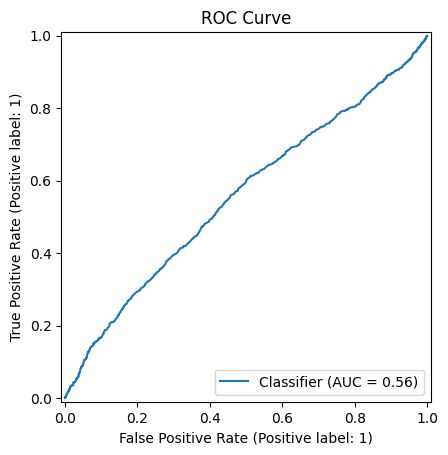

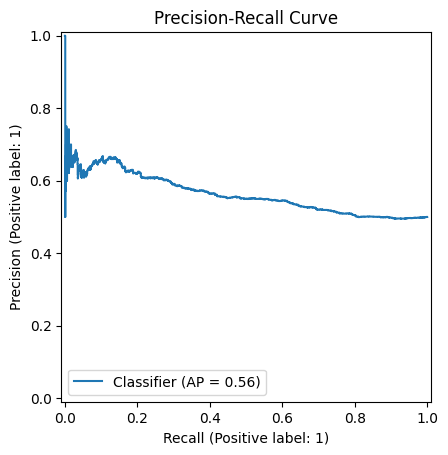


✅ 'test_metrics_summary.csv' 파일로 저장 완료!


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

# --- 설정 ---
CSV_PATH = "test_predictions.csv"  # CSV 파일 경로

# --- 1. CSV 불러오기 ---
df = pd.read_csv(CSV_PATH)

if not {"actual_label", "final_prediction", "predicted_probability"}.issubset(df.columns):
    raise ValueError("CSV 파일에 'actual_label', 'final_prediction', 'predicted_probability' 컬럼이 필요합니다.")

y_true = df["actual_label"].astype(int)
y_pred = df["final_prediction"].astype(int)
y_prob = df["predicted_probability"].astype(float)

# --- 2. 성능 지표 계산 ---
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, zero_division=0),
    "Recall": recall_score(y_true, y_pred, zero_division=0),
    "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_true, y_prob),
    "PR-AUC": average_precision_score(y_true, y_prob)
}

# --- 3. 혼동행렬 ---
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

# --- 4. 결과 출력 ---
print("\n📊 성능 지표")
for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

print("\n🔍 혼동행렬")
print(cm_df)

# --- 5. ROC Curve ---
RocCurveDisplay.from_predictions(y_true, y_prob)
plt.title("ROC Curve")
plt.show()

# --- 6. Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_true, y_prob)
plt.title("Precision-Recall Curve")
plt.show()

# --- 7. 지표를 CSV로 저장 ---
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("test_metrics_summary.csv", index=False, encoding="utf-8")
print("\n✅ 'test_metrics_summary.csv' 파일로 저장 완료!")


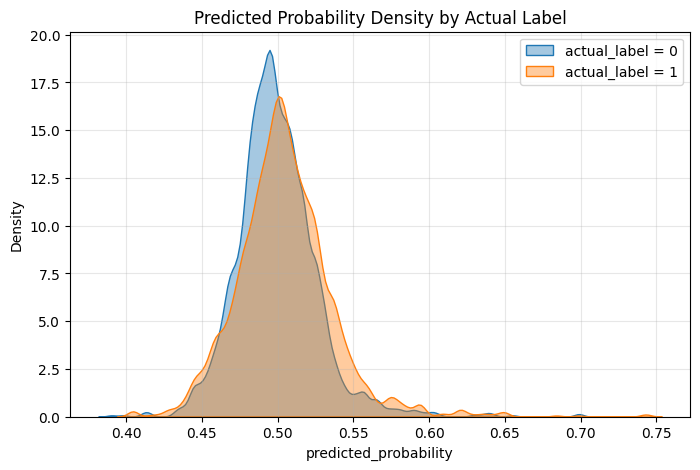

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 로드
df = pd.read_csv("test_predictions.csv")

plt.figure(figsize=(8, 5))

# 각 레이블별 PDF(KDE) 곡선
for label in sorted(df['actual_label'].unique()):
    subset = df[df['actual_label'] == label]
    sns.kdeplot(
        subset['predicted_probability'],
        fill=True,       # 색상 채우기
        alpha=0.4,
        label=f"actual_label = {label}",
        bw_adjust=0.5    # 커널 너비 조정 (값 작으면 더 세밀)
    )

plt.xlabel("predicted_probability")
plt.ylabel("Density")
plt.title("Predicted Probability Density by Actual Label")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
